# WeepingCAN Attack — Log Analysis

WeepingCAN **stealth variant**: deterministic injection · 1:5 recovery · skipping · jitter.

| § | Section |
|---|---------|
| 0 | Setup & Data Loading |
| 1 | TEC Timeline |
| 2 | Phase Analysis |
| 3 | Attack Success Rate & Jitter Effects |
| 4 | Bit Injection Distribution |
| 5 | Multi-run Comparison |
| 6 | Summary Statistics |

> **How to use:** configure `LOG_FILES` in §0 (leave empty for auto-pick), then *Run All*.

## §0 — Setup & Data Loading

In [17]:
import json
import re
import warnings
from pathlib import Path

try:
    from IPython.display import display
except ImportError:
    display = print
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec

warnings.filterwarnings('ignore')

# ── Dark GitHub-style theme ──────────────────────────────────────────────────
plt.rcParams.update({
    'figure.facecolor':  '#0d1117',
    'axes.facecolor':    '#161b22',
    'axes.edgecolor':    '#30363d',
    'axes.labelcolor':   '#c9d1d9',
    'axes.titlecolor':   '#e6edf3',
    'xtick.color':       '#8b949e',
    'ytick.color':       '#8b949e',
    'grid.color':        '#21262d',
    'grid.linewidth':    0.8,
    'text.color':        '#c9d1d9',
    'legend.facecolor':  '#161b22',
    'legend.edgecolor':  '#30363d',
    'legend.labelcolor': '#c9d1d9',
    'font.family':       'monospace',
    'font.size':         11,
    'axes.titlesize':    13,
    'axes.titleweight':  'bold',
    'axes.spines.top':   False,
    'axes.spines.right': False,
})

C_VICTIM    = '#f78166'   # red    — victim TEC
C_ATTACKER  = '#79c0ff'   # blue   — attacker TEC
C_INJECTION = '#56d364'   # green  — injection cycles
C_SKIP      = '#d29922'   # amber  — skip cycles
C_MISTIMED  = '#8957e5'   # purple — mis-timed cycles
C_PHASE1    = '#1f6feb'   # blue   — Error-Active band
C_PHASE2    = '#d29922'   # amber  — Error-Passive band
C_BUSOFF    = '#da3633'   # red    — Bus-Off
C_THRESH    = '#484f58'   # grey   — threshold lines

print('Libraries loaded.')

Libraries loaded.


In [18]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  CONFIGURE HERE                                              ║
# ╚══════════════════════════════════════════════════════════════╝
#
# Leave empty  →  auto-picks the most recent .jsonl in logs/
# One file     →  single-run analysis
# Multiple     →  §5 multi-run comparison is also enabled
#
# Examples:
#   LOG_FILES = []
#   LOG_FILES = ['logs/weepingcan_20260224_140242.jsonl']
#   LOG_FILES = ['logs/run_a.jsonl', 'logs/run_b.jsonl']

LOG_FILES = ['../logs/weepingcan_20260224_140242.jsonl', '../logs/weepingcan_20260224_144747.jsonl', '../logs/weepingcan_20260224_144753.jsonl']

In [19]:
# ── Locate logs directory (works from project root or Notebook/) ──────────────
def _find_logs_dir() -> Path:
    for c in [Path('logs'), Path('../logs')]:
        if c.is_dir():
            return c
    raise FileNotFoundError(
        "logs/ not found. Expected 'logs/' (project root) or '../logs/' (Notebook/)."
    )

if LOG_FILES:
    log_paths = [Path(p) for p in LOG_FILES]
else:
    _d = _find_logs_dir()
    _all = sorted(_d.glob('*.jsonl'), key=lambda p: p.stat().st_mtime)
    if not _all:
        raise FileNotFoundError(f'No .jsonl files in {_d.resolve()}')
    log_paths = [_all[-1]]

print(f'Files to analyse ({len(log_paths)}):')
for p in log_paths:
    print(f'  {p.resolve()}  ({p.stat().st_size / 1024:.1f} KB)')


# ── Parser ────────────────────────────────────────────────────────────────────
def parse_jsonl(path: Path) -> pd.DataFrame:
    """
    Parse a WeepingCAN .jsonl log into a per-cycle DataFrame.

    Columns
    -------
    cycle, victim_tec, attacker_tec, victim_state, attacker_state,
    action ('Injection' | 'Skip' | 'Mis-timed'),
    inject_pos (int or NaN)
    """
    raw = []
    with open(path, encoding='utf-8') as fh:
        for line in fh:
            line = line.strip()
            if line:
                try:
                    raw.append(json.loads(line))
                except json.JSONDecodeError:
                    pass

    rows, action, inject_pos = [], 'Injection', None

    for r in raw:
        level = r.get('level', '')
        msg   = r.get('message', '')

        if level == 'ATTACK':
            if 'ATTACK CYCLE' in msg:
                action, inject_pos = 'Injection', None
            elif 'SKIP CYCLE' in msg:
                action, inject_pos = 'Skip', None
            elif 'MIS-TIMED' in msg:
                action, inject_pos = 'Mis-timed', None
            m = re.search(r'recessive-inject-at bit (\d+)', msg)
            if m:
                inject_pos = int(m.group(1))

        if level == 'CYCLE' and 'cycle' in r:
            rows.append({
                'cycle':          r['cycle'],
                'victim_tec':     r['victim_tec'],
                'attacker_tec':   r['attacker_tec'],
                'victim_state':   r['victim_state'],
                'attacker_state': r['attacker_state'],
                'action':         action,
                'inject_pos':     inject_pos,
            })
            inject_pos = None

    return pd.DataFrame(rows).sort_values('cycle').reset_index(drop=True)


# ── Load all runs ─────────────────────────────────────────────────────────────
runs: dict[str, pd.DataFrame] = {}
for _p in log_paths:
    runs[_p.name] = parse_jsonl(_p)
    _df   = runs[_p.name]
    _n_i  = (_df['action'] == 'Injection').sum()
    _n_s  = (_df['action'] == 'Skip').sum()
    _n_m  = (_df['action'] == 'Mis-timed').sum()
    _bo   = _df[_df['victim_state'] == 'Bus-Off']['cycle']
    _bo_s = f'cycle {int(_bo.min())}' if not _bo.empty else 'not reached'
    print(f'  {_p.name}: {len(_df)} cycles  '
          f'(inj={_n_i}  skip={_n_s}  mis={_n_m}  bus-off={_bo_s})')

# Primary DataFrame (first / only run)
df  = next(iter(runs.values()))
RUN = next(iter(runs.keys()))

Files to analyse (3):
  /home/alessandrovulcu/Documenti/Università/CPS-Project-1/logs/weepingcan_20260224_140242.jsonl  (290.4 KB)
  /home/alessandrovulcu/Documenti/Università/CPS-Project-1/logs/weepingcan_20260224_144747.jsonl  (293.1 KB)
  /home/alessandrovulcu/Documenti/Università/CPS-Project-1/logs/weepingcan_20260224_144753.jsonl  (301.3 KB)
  weepingcan_20260224_140242.jsonl: 64 cycles  (inj=40  skip=23  mis=1  bus-off=cycle 64)
  weepingcan_20260224_144747.jsonl: 65 cycles  (inj=40  skip=23  mis=2  bus-off=cycle 65)
  weepingcan_20260224_144753.jsonl: 67 cycles  (inj=41  skip=23  mis=3  bus-off=cycle 67)


## §1 — TEC Timeline

Victim and attacker TEC over every cycle.  
Vertical tick marks show cycle action: **green** = injection · **amber** = skip · **purple** = mis-timed.

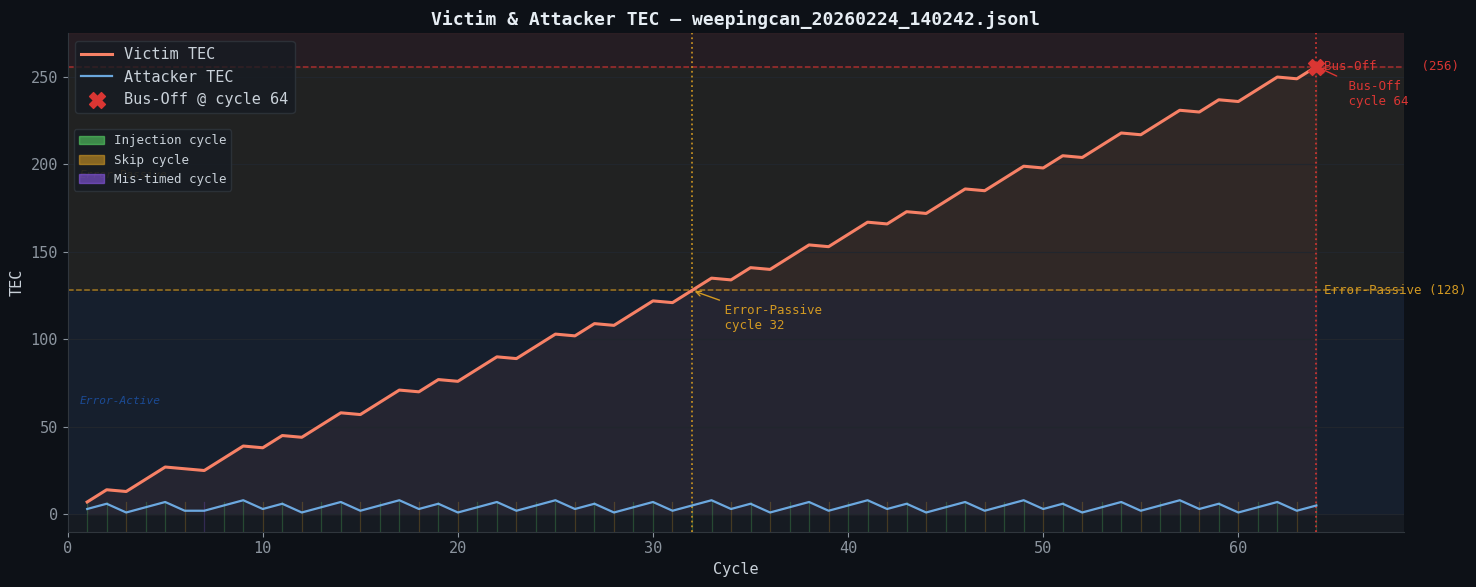

Saved: plot_tec_timeline.png


In [20]:
fig, ax = plt.subplots(figsize=(15, 6))

cyc   = df['cycle'].values
v_tec = df['victim_tec'].values
a_tec = df['attacker_tec'].values

# ── Background phase bands ────────────────────────────────────────────────────
ax.axhspan(  0, 127, alpha=0.06, color=C_PHASE1, zorder=0)
ax.axhspan(128, 255, alpha=0.06, color=C_PHASE2, zorder=0)
ax.axhspan(256, 275, alpha=0.08, color=C_BUSOFF,  zorder=0)

# ── Threshold lines ───────────────────────────────────────────────────────────
for y, lbl, col in [(128, 'Error-Passive (128)', C_PHASE2),
                     (256, 'Bus-Off      (256)', C_BUSOFF)]:
    ax.axhline(y, color=col, lw=1.1, ls='--', alpha=0.7, zorder=1)
    ax.text(cyc[-1] + 0.4, y, lbl, color=col, va='center', fontsize=9)

# ── Action tick marks at bottom ───────────────────────────────────────────────
ACTION_COLOR = {'Injection': C_INJECTION, 'Skip': C_SKIP, 'Mis-timed': C_MISTIMED}
for _, row in df.iterrows():
    col = ACTION_COLOR[row['action']]
    ax.axvline(row['cycle'], color=col, alpha=0.25, lw=0.9, ymin=0, ymax=0.06, zorder=2)

# ── TEC lines ─────────────────────────────────────────────────────────────────
ax.plot(cyc, v_tec, color=C_VICTIM,   lw=2.2, label='Victim TEC',   zorder=4)
ax.plot(cyc, a_tec, color=C_ATTACKER, lw=1.6, label='Attacker TEC', zorder=4, alpha=0.85)
ax.fill_between(cyc, v_tec, alpha=0.07, color=C_VICTIM)

# ── State-transition annotations ─────────────────────────────────────────────
for _, row in df[df['victim_state'] != df['victim_state'].shift(1)].iterrows():
    if row['victim_state'] in ('Error-Passive', 'Bus-Off'):
        col = C_PHASE2 if row['victim_state'] == 'Error-Passive' else C_BUSOFF
        ax.axvline(row['cycle'], color=col, lw=1.3, ls=':', alpha=0.9, zorder=3)
        ax.annotate(
            f" {row['victim_state']}\n cycle {int(row['cycle'])}",
            xy=(row['cycle'], row['victim_tec']),
            xytext=(row['cycle'] + len(cyc) * 0.02, row['victim_tec'] - 22),
            color=col, fontsize=9,
            arrowprops=dict(arrowstyle='->', color=col, lw=1),
        )

# ── Bus-Off marker ────────────────────────────────────────────────────────────
_bo = df[df['victim_state'] == 'Bus-Off']['cycle']
if not _bo.empty:
    ax.scatter([_bo.min()], [256], color=C_BUSOFF, s=130, zorder=6,
               marker='X', label=f'Bus-Off @ cycle {int(_bo.min())}')

# ── Legend for action colours ─────────────────────────────────────────────────
legend_patches = [
    mpatches.Patch(color=C_INJECTION, label='Injection cycle', alpha=0.6),
    mpatches.Patch(color=C_SKIP,      label='Skip cycle',      alpha=0.6),
    mpatches.Patch(color=C_MISTIMED,  label='Mis-timed cycle', alpha=0.6),
]
leg1 = ax.legend(loc='upper left')
leg2 = ax.legend(handles=legend_patches, loc='upper left',
                 bbox_to_anchor=(0, 0.82), fontsize=9)
ax.add_artist(leg1)

ax.set_title(f'Victim & Attacker TEC — {RUN}')
ax.set_xlabel('Cycle')
ax.set_ylabel('TEC')
ax.set_ylim(-10, 275)
ax.set_xlim(0, cyc[-1] + len(cyc) * 0.07)
ax.grid(True, axis='y')

# Band labels
for y_mid, lbl, col in [(63, 'Error-Active', C_PHASE1), (192, 'Error-Passive', C_PHASE2)]:
    ax.text(0.6, y_mid, lbl, color=col, fontsize=8, alpha=0.55, style='italic')

plt.tight_layout()
plt.savefig('plot_tec_timeline.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: plot_tec_timeline.png')

## §2 — Phase Analysis

**Phase 1** (Error-Active, TEC 0–127): victim retransmits normally, TEC +7/cycle net.  
**Phase 2** (Error-Passive, TEC 128–255): victim can no longer emit Active Error Flags; attacker's flag still corrupts frames.  
The bottom subplot shows ΔTEC per cycle, coloured by action type.

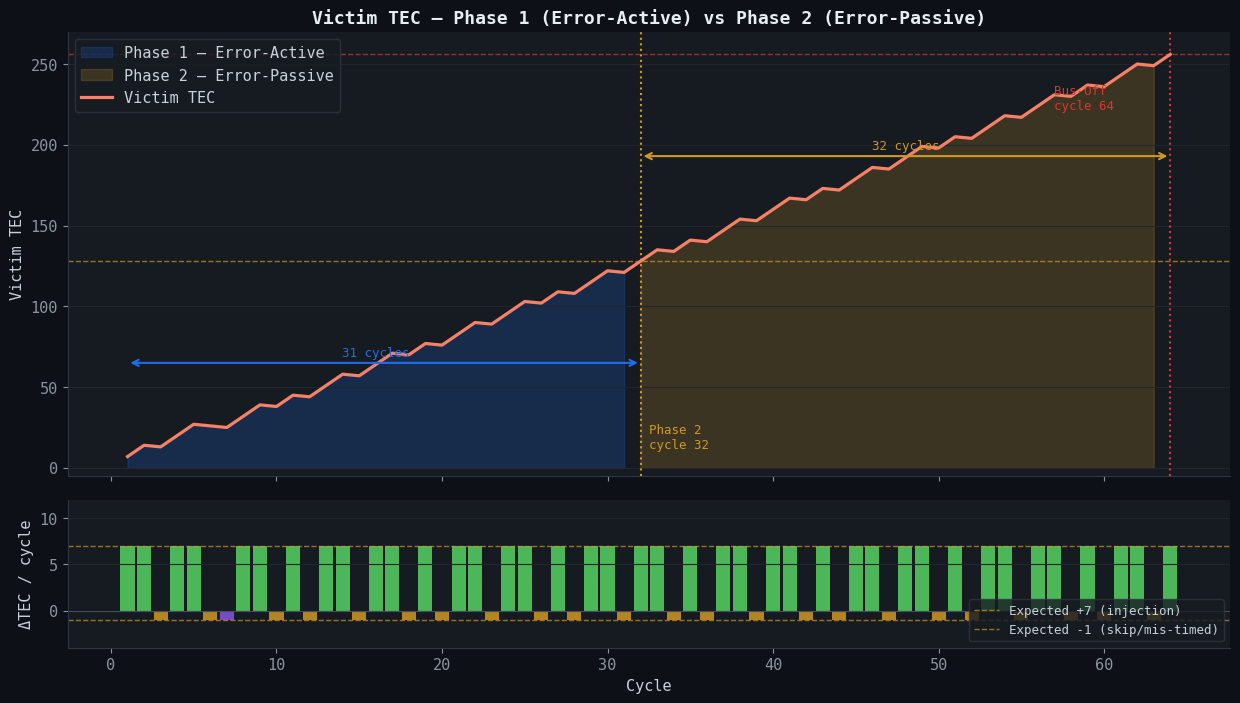

Saved: plot_phase_analysis.png


In [21]:
fig, (ax_main, ax_delta) = plt.subplots(
    2, 1, figsize=(15, 8),
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.08},
    sharex=True,
)

cyc   = df['cycle'].values
v_tec = df['victim_tec'].values

phase1_m = df['victim_state'] == 'Error-Active'
phase2_m = df['victim_state'] == 'Error-Passive'
busoff_m = df['victim_state'] == 'Bus-Off'

ph1_end = df[phase2_m]['cycle'].min() if phase2_m.any() else cyc[-1]
ph2_end = df[busoff_m]['cycle'].min() if busoff_m.any() else cyc[-1]

# ── Main: shaded phases + TEC ────────────────────────────────────────────────
ax_main.fill_between(cyc, v_tec, where=phase1_m.values,
                     color=C_PHASE1, alpha=0.20, label='Phase 1 — Error-Active')
ax_main.fill_between(cyc, v_tec, where=phase2_m.values,
                     color=C_PHASE2, alpha=0.20, label='Phase 2 — Error-Passive')
ax_main.plot(cyc, v_tec, color=C_VICTIM, lw=2.3, zorder=3, label='Victim TEC')
ax_main.axhline(128, color=C_PHASE2, lw=1,   ls='--', alpha=0.7)
ax_main.axhline(256, color=C_BUSOFF,  lw=1,   ls='--', alpha=0.7)

if not pd.isna(ph1_end):
    ax_main.axvline(ph1_end, color=C_PHASE2, lw=1.5, ls=':')
    ax_main.text(ph1_end + 0.5, 12, f'Phase 2\ncycle {int(ph1_end)}',
                 color=C_PHASE2, fontsize=9)
if not pd.isna(ph2_end):
    ax_main.axvline(ph2_end, color=C_BUSOFF, lw=1.5, ls=':')
    ax_main.text(ph2_end - len(cyc) * 0.11, 222, f'Bus-Off\ncycle {int(ph2_end)}',
                 color=C_BUSOFF, fontsize=9)

# Duration arrows
if not pd.isna(ph1_end):
    mid1 = ph1_end / 2
    ax_main.annotate('', xy=(ph1_end, 65), xytext=(1, 65),
                     arrowprops=dict(arrowstyle='<->', color=C_PHASE1, lw=1.5))
    ax_main.text(mid1, 69, f'{int(ph1_end - 1)} cycles',
                 color=C_PHASE1, ha='center', fontsize=9)
if not pd.isna(ph1_end) and not pd.isna(ph2_end):
    mid2 = (ph1_end + ph2_end) / 2
    ax_main.annotate('', xy=(ph2_end, 193), xytext=(ph1_end, 193),
                     arrowprops=dict(arrowstyle='<->', color=C_PHASE2, lw=1.5))
    ax_main.text(mid2, 197, f'{int(ph2_end - ph1_end)} cycles',
                 color=C_PHASE2, ha='center', fontsize=9)

ax_main.set_ylabel('Victim TEC')
ax_main.set_ylim(-5, 270)
ax_main.grid(True, axis='y')
ax_main.legend(loc='upper left')
ax_main.set_title('Victim TEC — Phase 1 (Error-Active) vs Phase 2 (Error-Passive)')

# ── Bottom: ΔTEC per cycle, coloured by action ────────────────────────────────
ACTION_COLOR = {'Injection': C_INJECTION, 'Skip': C_SKIP, 'Mis-timed': C_MISTIMED}
deltas = np.diff(v_tec, prepend=0)
bar_colors = [ACTION_COLOR[a] for a in df['action']]
ax_delta.bar(cyc, deltas, color=bar_colors, alpha=0.85, width=0.85)
ax_delta.axhline(7,  color=C_PHASE2, lw=1, ls='--', alpha=0.7, label='Expected +7 (injection)')
ax_delta.axhline(-1, color=C_SKIP,   lw=1, ls='--', alpha=0.7, label='Expected -1 (skip/mis-timed)')
ax_delta.axhline(0,  color=C_THRESH, lw=0.8)
ax_delta.set_ylabel('ΔTEC / cycle')
ax_delta.set_xlabel('Cycle')
ax_delta.legend(fontsize=9, loc='lower right')
ax_delta.set_ylim(-4, 12)
ax_delta.grid(True, axis='y')

plt.savefig('plot_phase_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: plot_phase_analysis.png')

## §3 — Attack Success Rate & Jitter Effects

**Top-left**: breakdown of cycles by action type (injection / skip / mis-timed).  
**Top-right**: attacker TEC oscillation — shows the skip mechanism keeping it below threshold.  
**Bottom**: cumulative victim TEC — actual vs ideal (no jitter, no skips).  
Mis-timed cycles waste a full cycle: victim TEC drops −1 instead of rising +7.

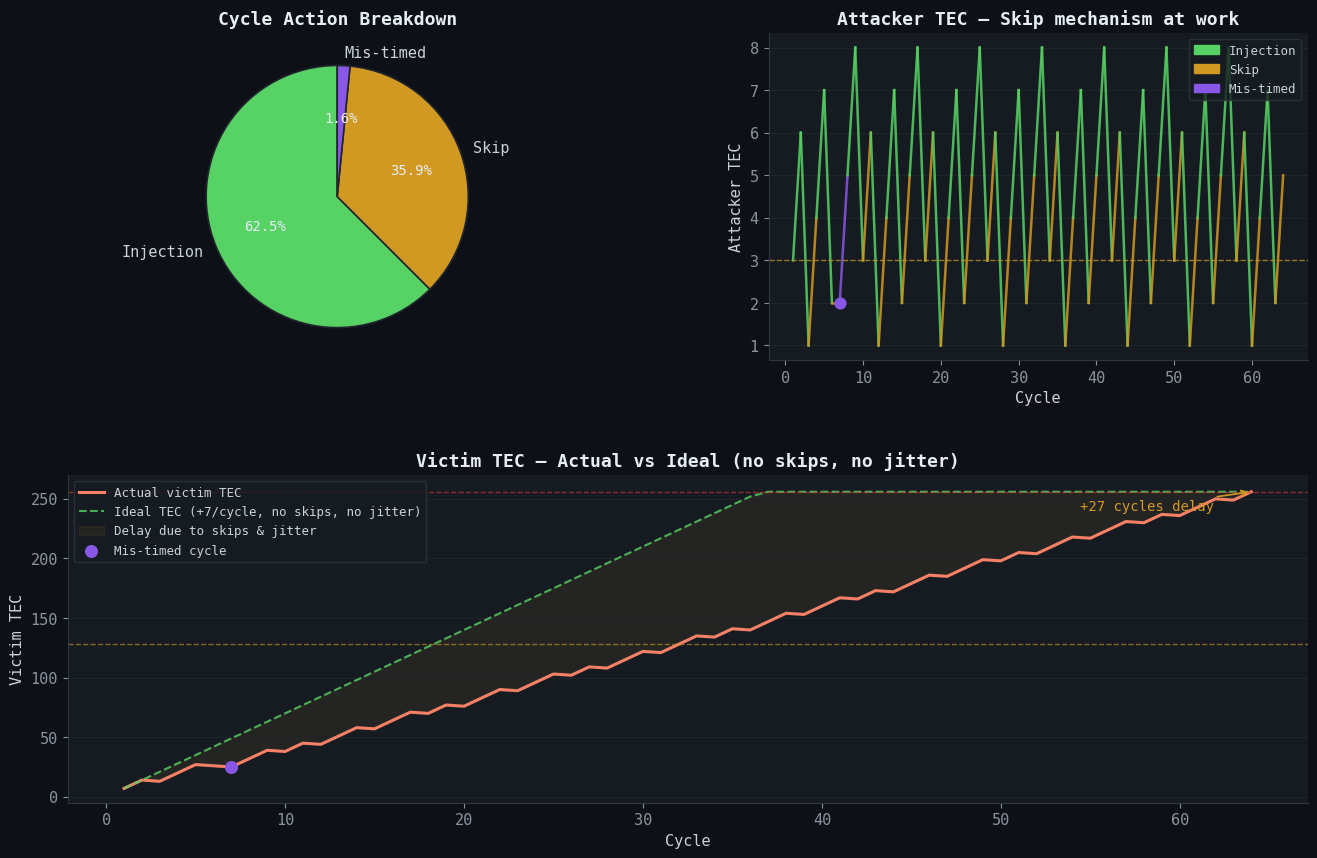

Saved: plot_success_rate.png


In [22]:
fig = plt.figure(figsize=(16, 10))
gs  = GridSpec(2, 2, figure=fig, hspace=0.35, wspace=0.30)

ax_pie  = fig.add_subplot(gs[0, 0])
ax_atk  = fig.add_subplot(gs[0, 1])
ax_cum  = fig.add_subplot(gs[1, :])

ACTION_COLOR = {'Injection': C_INJECTION, 'Skip': C_SKIP, 'Mis-timed': C_MISTIMED}
cyc   = df['cycle'].values
v_tec = df['victim_tec'].values
a_tec = df['attacker_tec'].values

# ── Top-left: action breakdown pie ───────────────────────────────────────────
counts = df['action'].value_counts()
_order = [a for a in ('Injection', 'Skip', 'Mis-timed') if a in counts]
_sizes = [counts[a] for a in _order]
_cols  = [ACTION_COLOR[a] for a in _order]
wedges, texts, autotexts = ax_pie.pie(
    _sizes, labels=_order, colors=_cols, autopct='%1.1f%%',
    startangle=90, wedgeprops=dict(edgecolor='#21262d', linewidth=1.2),
)
for at in autotexts:
    at.set_color('#e6edf3')
    at.set_fontsize(10)
for t in texts:
    t.set_color('#c9d1d9')
ax_pie.set_title('Cycle Action Breakdown')

# ── Top-right: attacker TEC over cycles ──────────────────────────────────────
# Colour each segment by action to show when skips pull it down
for i in range(len(cyc) - 1):
    col = ACTION_COLOR[df.iloc[i]['action']]
    ax_atk.plot(cyc[i:i+2], a_tec[i:i+2], color=col, lw=1.8, alpha=0.85)

# Also draw dots for mis-timed
mis_mask = df['action'] == 'Mis-timed'
if mis_mask.any():
    ax_atk.scatter(df[mis_mask]['cycle'], df[mis_mask]['attacker_tec'],
                   color=C_MISTIMED, s=60, zorder=5, label='Mis-timed')

# Threshold line
skip_thresh = df[df['action'] == 'Skip']['attacker_tec'].max() if (df['action'] == 'Skip').any() else None
if skip_thresh:
    ax_atk.axhline(skip_thresh, color=C_SKIP, lw=1, ls='--', alpha=0.7,
                   label=f'Skip threshold (~{int(skip_thresh)})')

legend_patches = [mpatches.Patch(color=c, label=a)
                  for a, c in ACTION_COLOR.items() if a in counts]
ax_atk.legend(handles=legend_patches, fontsize=9, loc='upper right')
ax_atk.set_title('Attacker TEC — Skip mechanism at work')
ax_atk.set_xlabel('Cycle')
ax_atk.set_ylabel('Attacker TEC')
ax_atk.grid(True, axis='y')

# ── Bottom: cumulative TEC — actual vs ideal ─────────────────────────────────
# Ideal: every cycle is a successful injection (+7) — no skips, no jitter
ideal_tec = np.minimum(np.arange(1, len(cyc) + 1) * 7, 256)

ax_cum.plot(cyc, v_tec,    color=C_VICTIM,   lw=2.2, label='Actual victim TEC')
ax_cum.plot(cyc, ideal_tec, color=C_INJECTION, lw=1.5, ls='--', alpha=0.8,
            label='Ideal TEC (+7/cycle, no skips, no jitter)')
ax_cum.fill_between(cyc, v_tec, ideal_tec, alpha=0.08, color=C_SKIP,
                    label='Delay due to skips & jitter')

ax_cum.axhline(128, color=C_PHASE2, lw=1, ls='--', alpha=0.6)
ax_cum.axhline(256, color=C_BUSOFF,  lw=1, ls='--', alpha=0.6)

# Mark mis-timed cycles
if mis_mask.any():
    ax_cum.scatter(df[mis_mask]['cycle'], df[mis_mask]['victim_tec'],
                   color=C_MISTIMED, s=70, zorder=5, label='Mis-timed cycle')

# Cycle delay
ideal_busoff = 256 // 7 + 1
actual_busoff = df[df['victim_state'] == 'Bus-Off']['cycle']
if not actual_busoff.empty:
    delay = int(actual_busoff.min()) - ideal_busoff
    ax_cum.annotate(
        f'+{delay} cycles delay',
        xy=(actual_busoff.min(), 256),
        xytext=(actual_busoff.min() - len(cyc) * 0.15, 240),
        color=C_SKIP, fontsize=10,
        arrowprops=dict(arrowstyle='->', color=C_SKIP, lw=1.2),
    )

ax_cum.set_title('Victim TEC — Actual vs Ideal (no skips, no jitter)')
ax_cum.set_xlabel('Cycle')
ax_cum.set_ylabel('Victim TEC')
ax_cum.set_ylim(-5, 270)
ax_cum.legend(fontsize=9, loc='upper left')
ax_cum.grid(True, axis='y')

plt.savefig('plot_success_rate.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: plot_success_rate.png')

## §4 — Bit Injection Distribution

The attacker uses a pre-computed **safe pool** of bit positions where the victim's frame is guaranteed to be dominant (0). Injecting a recessive (1) at these positions always triggers a Bit Error.

- **Left**: histogram of the injection positions used across all cycles  
- **Right**: frequency of each position, coloured by how often it was chosen

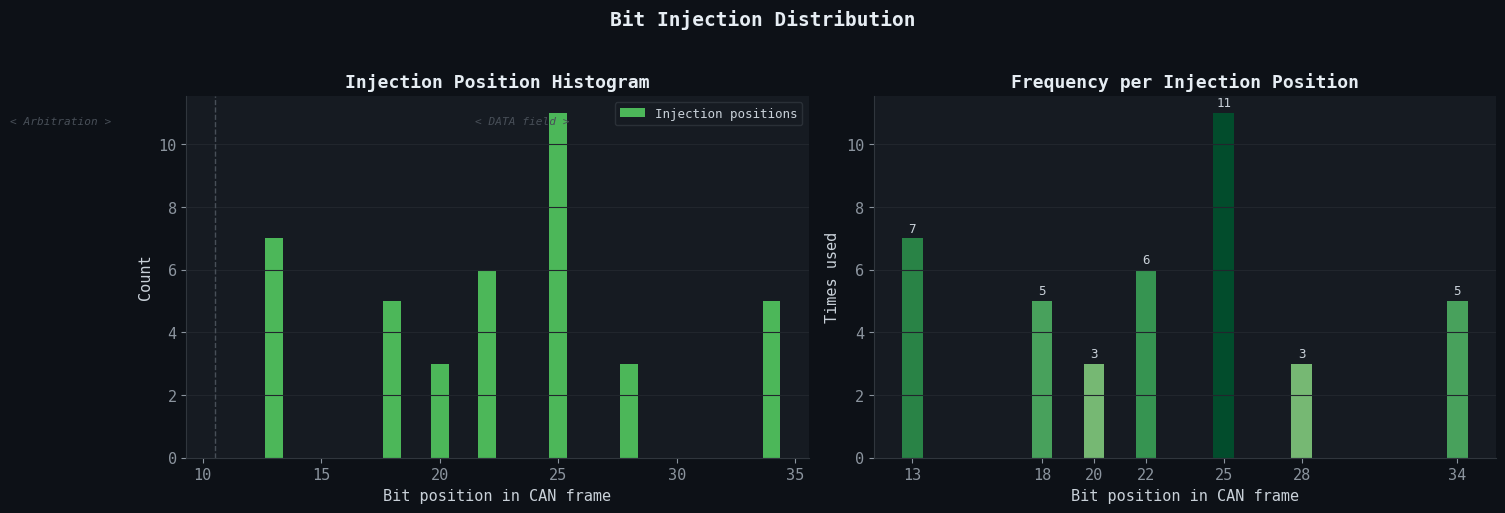

Saved: plot_injection_dist.png
Safe pool used: [13, 18, 20, 22, 25, 28, 34]


In [23]:
inj_df = df[df['action'] == 'Injection'].dropna(subset=['inject_pos'])
positions = inj_df['inject_pos'].astype(int).values

if len(positions) == 0:
    print('No injection positions recorded in this log.')
else:
    fig, (ax_hist, ax_bar) = plt.subplots(1, 2, figsize=(15, 5))

    # ── Left: histogram ───────────────────────────────────────────────────────
    pos_min, pos_max = int(positions.min()), int(positions.max())
    bins = np.arange(pos_min, pos_max + 2) - 0.5

    ax_hist.hist(positions, bins=bins, color=C_INJECTION, alpha=0.85,
                 rwidth=0.75, label='Injection positions')
    ax_hist.set_title('Injection Position Histogram')
    ax_hist.set_xlabel('Bit position in CAN frame')
    ax_hist.set_ylabel('Count')
    ax_hist.grid(True, axis='y')

    # Annotate CAN frame regions
    ax_hist.axvline(10.5, color=C_THRESH, lw=1, ls='--')
    ax_hist.text(4,  ax_hist.get_ylim()[1] * 0.92, '< Arbitration >', color=C_THRESH,
                 fontsize=8, ha='center', style='italic')
    ax_hist.text(pos_min + (pos_max - pos_min) * 0.5,
                 ax_hist.get_ylim()[1] * 0.92,
                 '< DATA field >', color=C_THRESH, fontsize=8, ha='center', style='italic')
    ax_hist.legend(fontsize=9)

    # ── Right: per-position frequency bar ────────────────────────────────────
    unique_pos, freq = np.unique(positions, return_counts=True)
    norm_freq = freq / freq.max()
    bar_colors = plt.cm.YlGn(0.3 + norm_freq * 0.65)

    bars = ax_bar.bar(unique_pos, freq, color=bar_colors, alpha=0.9, width=0.8)
    for bar, cnt in zip(bars, freq):
        ax_bar.text(bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + 0.1, str(cnt),
                    ha='center', va='bottom', fontsize=9, color='#c9d1d9')

    ax_bar.set_title('Frequency per Injection Position')
    ax_bar.set_xlabel('Bit position in CAN frame')
    ax_bar.set_ylabel('Times used')
    ax_bar.set_xticks(unique_pos)
    ax_bar.grid(True, axis='y')

    plt.suptitle('Bit Injection Distribution', fontsize=14, fontweight='bold',
                 color='#e6edf3', y=1.02)
    plt.tight_layout()
    plt.savefig('plot_injection_dist.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: plot_injection_dist.png')
    print(f'Safe pool used: {sorted(unique_pos.tolist())}')

## §5 — Multi-run Comparison

Active only when **multiple** `.jsonl` files are loaded in §0.  
Shows TEC timeline overlay, cycle-count distribution, and a comparison table.

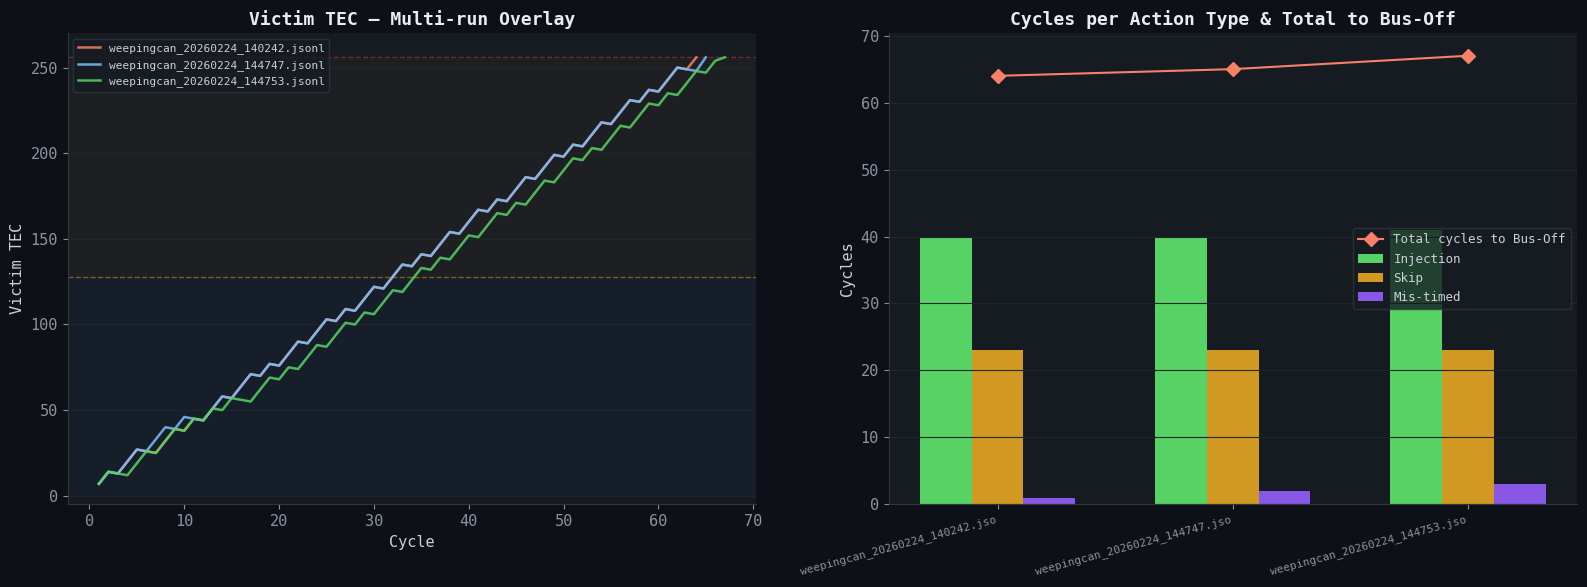

Saved: plot_multirun.png


,Total cycles,Bus-Off cycle,Error-Passive @,Injection,Skip,Mis-timed,Atk TEC peak
Run,,,,,,,
weepingcan_20260224_140242.jsonl,64,64,32,40,23,1,8
weepingcan_20260224_144747.jsonl,65,65,32,40,23,2,8
weepingcan_20260224_144753.jsonl,67,67,35,41,23,3,8


In [24]:
if len(runs) < 2:
    print('Only one run loaded — pass multiple LOG_FILES in §0 to enable this section.')
else:
    _palette = ['#f78166','#79c0ff','#56d364','#d29922','#8957e5','#da3633']
    _labels  = list(runs.keys())

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # ── Left: TEC timeline overlay ────────────────────────────────────────────
    ax = axes[0]
    ax.axhline(128, color=C_PHASE2, lw=1, ls='--', alpha=0.5)
    ax.axhline(256, color=C_BUSOFF,  lw=1, ls='--', alpha=0.5)
    ax.axhspan(  0, 127, alpha=0.04, color=C_PHASE1)
    ax.axhspan(128, 255, alpha=0.04, color=C_PHASE2)

    for i, (name, rdf) in enumerate(runs.items()):
        col = _palette[i % len(_palette)]
        ax.plot(rdf['cycle'], rdf['victim_tec'], color=col, lw=1.8,
                label=name, alpha=0.85)

    ax.set_title('Victim TEC — Multi-run Overlay')
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Victim TEC')
    ax.set_ylim(-5, 270)
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(True, axis='y')

    # ── Right: cycles-to-bus-off bar chart ────────────────────────────────────
    ax2   = axes[1]
    names = []
    totals, inj_cnts, skip_cnts, mis_cnts = [], [], [], []

    for name, rdf in runs.items():
        names.append(name[:30])
        _bo = rdf[rdf['victim_state'] == 'Bus-Off']['cycle']
        totals.append(int(_bo.min()) if not _bo.empty else len(rdf))
        inj_cnts.append( int((rdf['action'] == 'Injection').sum()))
        skip_cnts.append(int((rdf['action'] == 'Skip').sum()))
        mis_cnts.append( int((rdf['action'] == 'Mis-timed').sum()))

    x = np.arange(len(names))
    w = 0.22
    ax2.bar(x - w,   inj_cnts,  width=w, color=C_INJECTION, label='Injection')
    ax2.bar(x,       skip_cnts, width=w, color=C_SKIP,      label='Skip')
    ax2.bar(x + w,   mis_cnts,  width=w, color=C_MISTIMED,  label='Mis-timed')
    ax2.plot(x, totals, color=C_VICTIM, marker='D', lw=1.5,
             ms=7, label='Total cycles to Bus-Off', zorder=5)

    ax2.set_xticks(x)
    ax2.set_xticklabels(names, rotation=15, ha='right', fontsize=8)
    ax2.set_title('Cycles per Action Type & Total to Bus-Off')
    ax2.set_ylabel('Cycles')
    ax2.legend(fontsize=9)
    ax2.grid(True, axis='y')

    plt.tight_layout()
    plt.savefig('plot_multirun.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: plot_multirun.png')

    # ── Comparison table ──────────────────────────────────────────────────────
    rows = []
    for name, rdf in runs.items():
        _bo   = rdf[rdf['victim_state'] == 'Bus-Off']['cycle']
        _ph2  = rdf[rdf['victim_state'] == 'Error-Passive']['cycle']
        rows.append({
            'Run':             name,
            'Total cycles':    len(rdf),
            'Bus-Off cycle':   int(_bo.min())  if not _bo.empty  else 'N/A',
            'Error-Passive @': int(_ph2.min()) if not _ph2.empty else 'N/A',
            'Injection':       int((rdf['action'] == 'Injection').sum()),
            'Skip':            int((rdf['action'] == 'Skip').sum()),
            'Mis-timed':       int((rdf['action'] == 'Mis-timed').sum()),
            'Atk TEC peak':    int(rdf['attacker_tec'].max()),
        })
    display(pd.DataFrame(rows).set_index('Run'))

## §6 — Summary Statistics

In [25]:
total   = len(df)
n_inj   = int((df['action'] == 'Injection').sum())
n_skip  = int((df['action'] == 'Skip').sum())
n_mis   = int((df['action'] == 'Mis-timed').sum())

busoff_c  = df[df['victim_state'] == 'Bus-Off']['cycle']
phase2_c  = df[df['victim_state'] == 'Error-Passive']['cycle']

ph1_len = int(phase2_c.min() - 1)                       if not phase2_c.empty else total
ph2_len = int(busoff_c.min() - phase2_c.min())          if not busoff_c.empty and not phase2_c.empty else 'N/A'
bo_at   = int(busoff_c.min())                            if not busoff_c.empty else 'not reached'

deltas  = np.diff(df['victim_tec'].values)
avg_net = deltas.mean()

ideal_bo = 256 // 7 + 1
delay    = (int(busoff_c.min()) - ideal_bo) if not busoff_c.empty else 'N/A'

rows = [
    ('Log file',                         RUN),
    ('Total cycles',                     total),
    ('─' * 26,                           '─' * 22),
    ('Injection cycles',                 f'{n_inj}  ({n_inj/total*100:.1f}%)'),
    ('Skip cycles',                      f'{n_skip}  ({n_skip/total*100:.1f}%)'),
    ('Mis-timed cycles',                 f'{n_mis}  ({n_mis/total*100:.1f}%)'),
    ('─' * 26,                           '─' * 22),
    ('Error-Passive starts at cycle',    int(phase2_c.min()) if not phase2_c.empty else 'N/A'),
    ('Phase 1 duration (Error-Active)',  f'{ph1_len} cycles'),
    ('Phase 2 duration (Error-Passive)', f'{ph2_len} cycles'),
    ('Victim Bus-Off at cycle',          bo_at),
    ('─' * 26,                           '─' * 22),
    ('Ideal Bus-Off (no skip/jitter)',   f'cycle {ideal_bo}'),
    ('Actual delay vs ideal',            f'+{delay} cycles' if isinstance(delay, int) else delay),
    ('Avg ΔTEC / cycle (actual)',        f'{avg_net:+.2f}'),
    ('─' * 26,                           '─' * 22),
    ('Attacker TEC peak',                int(df['attacker_tec'].max())),
    ('Attacker TEC final',               int(df['attacker_tec'].iloc[-1])),
    ('Attacker final state',             df['attacker_state'].iloc[-1]),
    ('Attacker stayed Error-Active?',    'YES' if (df['attacker_state'] == 'Error-Active').all() else 'NO'),
]

summary = pd.DataFrame(rows, columns=['Metric', 'Value']).set_index('Metric')
styled = summary.style.set_table_styles([
    {'selector': 'th', 'props': [
        ('background-color','#161b22'),('color','#79c0ff'),
        ('font-family','monospace'),('border','1px solid #30363d')]},
    {'selector': 'td', 'props': [
        ('background-color','#0d1117'),('color','#c9d1d9'),
        ('font-family','monospace'),('border','1px solid #21262d'),
        ('padding','5px 14px')]},
]).set_caption(f'WeepingCAN Simulation — Summary  ({RUN})')
display(styled)

,Value
Metric,
Log file,weepingcan_20260224_140242.jsonl
Total cycles,64
──────────────────────────,──────────────────────
Injection cycles,40 (62.5%)
Skip cycles,23 (35.9%)
Mis-timed cycles,1 (1.6%)
──────────────────────────,──────────────────────
Error-Passive starts at cycle,32
Phase 1 duration (Error-Active),31 cycles
